In [1]:
import numpy as np
from matplotlib import pyplot as plt
from petitRADTRANS import Radtrans
import h5py

# k-coefficients

In [2]:
species = [
    'H2O',
    'CO',
    'CO2',
    'CH4',
    'O3',
    'O2',
    'NH3',
    'C2H2',
    'C2H4',
    'H2S',
    'HCN'
]

pspecies = [
    'H2O_HITEMP',
    'CO_12_HITEMP',
    'CO2',
    'CH4',
    'O3',
    'O2',
    'NH3',
    'C2H2',
    'C2H4',
    'H2S',
    'HCN'
]


In [3]:
atmosphere = Radtrans(line_species = pspecies,
                      wlen_bords_micron = [0.1, 251.]) # DO NOT CHANGE THESE WAVELENGTH BOUNDS FOR THE REBINNING!

  Read line opacities of H2O_HITEMP...
 Done.
  Read line opacities of CO_12_HITEMP...
 Done.
  Read line opacities of CO2...
 Done.
  Read line opacities of CH4...
 Done.
  Read line opacities of O3...
 Done.
  Read line opacities of O2...
 Done.
  Read line opacities of NH3...
 Done.
  Read line opacities of C2H2...
 Done.
  Read line opacities of C2H4...
 Done.
  Read line opacities of H2S...
 Done.
  Read line opacities of HCN...
 Done.



In [4]:
from molmass import Formula

masses = {}
for spec in species:
    f = Formula(spec)
    masses[spec] = f.isotope.massnumber

print(masses)

{'H2O': 18, 'CO': 28, 'CO2': 44, 'CH4': 16, 'O3': 48, 'O2': 32, 'NH3': 17, 'C2H2': 26, 'C2H4': 28, 'H2S': 34, 'HCN': 27}


In [5]:
R = 10
atmosphere.write_out_rebin(R,
                           path='rebin_RADTRANS',
                           species = pspecies,
                           masses = masses)

Rebinning species H2O_HITEMP...
Rebinning species CO_12_HITEMP...
Rebinning species CO2...
Rebinning species CH4...
Rebinning species O3...
Rebinning species O2...
Rebinning species NH3...
Rebinning species C2H2...
Rebinning species C2H4...
Rebinning species H2S...
Rebinning species HCN...


In [6]:
# new wavenumbers bin edges I want to save the data at
wavnum_N = np.array([4.05256468e+04, 3.66559428e+04, 3.31557483e+04, 2.99897796e+04,
       2.71261222e+04, 2.45359090e+04, 2.21930296e+04, 2.00738665e+04,
       1.81570576e+04, 1.64232805e+04, 1.48550579e+04, 1.34365815e+04,
       1.21535521e+04, 1.09930365e+04, 9.94333583e+03, 8.99386879e+03,
       8.13506424e+03, 7.35826503e+03, 6.65564065e+03, 6.02010831e+03,
       5.44526155e+03, 4.92530562e+03, 4.45499913e+03, 4.02960116e+03,
       3.64482350e+03, 3.29678740e+03, 2.98198450e+03, 2.69724142e+03,
       2.43968783e+03, 2.20672746e+03, 1.99601196e+03, 1.80541721e+03,
       1.63302193e+03, 1.47708830e+03, 1.33604442e+03, 1.20846851e+03,
       1.09307453e+03, 9.88699275e+02, 8.94290578e+02, 8.08896757e+02,
       7.31657003e+02, 6.61792702e+02, 5.98599587e+02, 5.41440642e+02,
       4.89739679e+02, 4.42975525e+02, 4.00676776e+02, 3.62417041e+02,
       3.27810643e+02, 2.96508733e+02, 2.68195773e+02, 2.42586354e+02,
       2.19422322e+02, 1.98470172e+02, 1.79518697e+02, 1.62376855e+02,
       1.46871850e+02, 1.32847383e+02, 1.20162082e+02, 1.08688072e+02,
       9.83096892e+01, 8.89223154e+01, 8.04313211e+01, 7.27511130e+01,
       6.58042708e+01, 5.95207672e+01, 5.38372614e+01, 4.86964609e+01,
       4.40465441e+01, 3.98406375e+01])

In [7]:
def read_petit_file(file, wavnum_N):

    with h5py.File(file, 'r') as f:

        kcoeff = f['kcoeff'][:,:,:,:]

        wavnum = f['bin_edges'][:]
        ind0 = np.argmin(np.abs(wavnum-np.min(wavnum_N)))
        ind1 = np.argmin(np.abs(wavnum-np.max(wavnum_N)))

        if not np.all(np.isclose(wavnum[ind0:ind1+1],wavnum_N[::-1])):
            raise Exception("wavenumbers are not consistent")

        T = f['t'][:]
        nT = len(T)

        P = f['p'][:]
        nP = len(P)

        weights = f['weights'][:]
        ngauss = len(weights)

        kcoeff1 = kcoeff[:,:,ind0:ind1,:]
        nw = kcoeff1.shape[2]
        kcoeff_N = np.empty((ngauss,nP,nT,nw),order='F')

        # reorder elements
        for i in range(nP):
            for j in range(nT):
                for k in range(kcoeff1.shape[2]):
                    kk = kcoeff1.shape[2]-k-1
                    for l in range(ngauss):
                        kcoeff_N[l,i,j,kk] = kcoeff1[i,j,k,l]  


        log10_kcoeff_N = np.log10(kcoeff_N)
        
    return weights, T, P, log10_kcoeff_N
    
    

def create_k_dataset(filename, sp, notes, weights, T, log10P, wavelengths, log10k):

    with h5py.File(filename, "w") as f:

        l = "50"
        dset = f.create_dataset("species",(),dtype="S"+l)
        dset[()] = ('{:'+l+'}').format(sp).encode()

        dset = f.create_dataset("notes",(),dtype="S1000")
        dset[()] = '{:1000}'.format(notes).encode()

        dset = f.create_dataset("weights", weights.shape, 'f')
        dset[:] = weights
        
        dset = f.create_dataset("T", T.shape, 'f')
        dset[:] = T
        
        dset = f.create_dataset("log10P", log10P.shape, 'f')
        dset[:] = log10P
        
        dset = f.create_dataset("wavelengths", wavelengths.shape, 'f')
        dset[:] = wavelengths

        dset = f.create_dataset("log10k", log10k.T.shape, 'f')
        dset[:] = log10k.T

In [8]:
notes = \
"""petitRADTRANS k-coeff database downbined to R = 10.
Reference DOI: 10.1051/0004-6361/201935470
Date: 4/16/22
Creator: Nick Wogan
Email: nicholaswogan@gmail.com

units:
wavelengths: [um]
log10P: [bar]
T: [K]
log10k: [cm^2/molecule]
"""

In [9]:
# loop over all species
for i,spec in enumerate(pspecies):
    file = "rebin_RADTRANS/"+spec+"_R_10/"+spec+"_R_10.h5"
    sp = species[i]
    outfilename = "kdistributions/"+sp+".h5"
    
    weights, T, P, log10_kcoeff_N = read_petit_file(file, wavnum_N)
    log10P = np.log10(P)
    wavl_N = 1e4/wavnum_N
    create_k_dataset(outfilename, sp, notes, weights, T, log10P, wavl_N, log10_kcoeff_N)
    

In [12]:
sol_wavl = \
np.array([0.24675732, 0.27280706, 0.30160683, 0.33344693, 0.36864834,
       0.40756591, 0.45059193, 0.49816013, 0.55075003, 0.60889175,
       0.67317139, 0.74423692, 0.82280471, 0.90966677, 1.00569871,
       1.11186857, 1.22924659, 1.35901601, 1.50248496, 1.66109968,
       1.83645908, 2.03033086, 2.24466935, 2.48163518, 2.74361708,
       3.03325595, 3.35347149, 3.70749163, 4.09888506, 4.5315972 ])

ir_wavl = \
np.array([  0.30160683,   0.33344693,   0.36864834,   0.40756591,
         0.45059193,   0.49816013,   0.55075003,   0.60889175,
         0.67317139,   0.74423692,   0.82280471,   0.90966677,
         1.00569871,   1.11186857,   1.22924659,   1.35901601,
         1.50248496,   1.66109968,   1.83645908,   2.03033086,
         2.24466935,   2.48163518,   2.74361708,   3.03325595,
         3.35347149,   3.70749163,   4.09888506,   4.5315972 ,
         5.00999002,   5.53888593,   6.12361646,   6.77007597,
         7.48478109,   8.27493638,   9.14850698,  10.11429891,
        11.18204782,  12.36251711,  13.66760648,  15.11047187,
        16.70565803,  18.46924522,  20.41901124,  22.57461065,
        24.95777294,  27.59252151,  30.50541589,  33.72581946,
        37.28619542,  41.22243405,  45.57421454,  50.38540491,
        55.70450425,  61.58513163,  68.0865666 ,  75.27434672,
        83.22092825,  92.00641654, 101.71937351, 112.45771041,
       124.32967482, 137.4549418 , 151.96582034, 168.00858702,
       185.74496061, 205.35373223, 227.03256769, 251.        ])

In [13]:
with h5py.File("kdistributions/bins.h5", "w") as f:
    dset = f.create_dataset("sol_wavl", sol_wavl.shape, 'f')
    dset[:] = sol_wavl
    
    dset = f.create_dataset("ir_wavl", ir_wavl.shape, 'f')
    dset[:] = ir_wavl

# CIA

In [15]:
import os

In [17]:
rt_path = os.environ["pRT_input_data_path"]

In [19]:


def get_cia(sp):

    Pstp = 1
    C = 1/1.013e6
    Tstp = 273.15
    k = 1.3807e-16
    Ca = (Pstp*(1/C))/(k*Tstp) # (molecules/cm3)/(amagat)

    filename = rt_path+"/opacities/continuum/CIA/"+sp+"/temps.dat"
    f = open(filename,'r')
    lines = f.readlines()
    f.close()

    T = np.array([float(a.strip()) for a in lines],dtype=np.float64)
    nT = len(T)

    filename = rt_path+"/opacities/continuum/CIA/"+sp+"/CIA_"+sp+"_final.dat"
    f = open(filename,'r')
    lines = f.readlines()
    f.close()

    nw = len(lines[2:])
    wv = np.empty(nw,np.float64)
    log10xs = np.empty((nT,nw),np.float64)

    for i,line in enumerate(lines[2:]):
        wv[i] = float(line.split()[0])*1e4
        tmp = np.array([float(a) for a in line.split()[1:]])
        tmp = np.clip(tmp, a_min=0, a_max=np.inf)
        log10xs[:,i] = np.log10(tmp*(1/Ca)**2 + np.sqrt(np.finfo(np.float64).tiny))

    return wv, T, log10xs

In [20]:
def write_CIA(filename, notes, wv, T, log10xs):
    with h5py.File(filename, "w") as f:

        dset = f.create_dataset("notes",(),dtype="S1000")
        dset[()] = '{:1000}'.format(notes).encode()

        dset = f.create_dataset("wavelengths", wv.shape, 'f')
        dset[:] = wv

        dset = f.create_dataset("T", T.shape, 'f')
        dset[:] = T

        dset = f.create_dataset("log10xs", log10xs.T.shape, 'f')
        dset[:,:] = log10xs.T

In [21]:
sp1 = "H2"
sp2 = "H2"

wv, T, log10xs = get_cia(sp1+sp2)
s = int(len(wv)/500)
wv = wv[::s]
log10xs = log10xs[:,::s]

notes = \
sp1+'-'+sp2+""" CIA from Mollière et al. 2019 downsampled to approximately 500 points
wavelengths = [um]
T = [K]
log10xs = [cm^2/molecule]
"""

# write_CIA(sp1+'-'+sp2+".h5", notes, wv, T, log10xs)

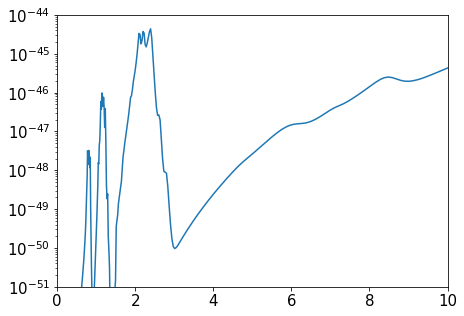

In [23]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[7,5])

s = 10
ax.plot(wv,10**log10xs[0,:])

ax.set_yscale('log')
ax.set_xlim(0,10)
ax.set_ylim(1e-51,1e-44)

plt.show()